In [41]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [15]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine, func, text
from sqlalchemy.engine import reflection

In [16]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

#got attribute error in the next cell when using the names of the csv files. So adding the step to check available tables in the db.
inspector = reflection.Inspector.from_engine(engine)
available_tables = inspector.get_table_names()
print(available_tables)

['measurement', 'station']


/var/folders/h6/rstm4b2j0g928d95j1p6tr400000gn/T/ipykernel_57245/2861996026.py:5: SADeprecationWarning: The from_engine() method on Inspector is deprecated and will be removed in a future release.  Please use the sqlalchemy.inspect() function on an Engine or Connection in order to acquire an Inspector. (deprecated since: 1.4)
  inspector = reflection.Inspector.from_engine(engine)


In [17]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine,reflect=True)
# reflect the tables
measurement = Base.classes.measurement
station = Base.classes.station

/var/folders/h6/rstm4b2j0g928d95j1p6tr400000gn/T/ipykernel_57245/4291945355.py:3: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine,reflect=True)


In [18]:
# View all of the classes that automap found
classes = Base.classes.keys()
print(classes)

['measurement', 'station']


In [19]:
# Save references to each table
tables = {}
for class_name in Base.classes.keys():
    table_reference = getattr(Base.classes, class_name)
    tables[measurement] = table_reference
    tables[station] = table_reference


In [20]:
# Create our session (link) from Python to the DB

Session = sessionmaker(bind=engine)
session = Session()
print(session.bind)


Engine(sqlite:///Resources/hawaii.sqlite)


# Exploratory Precipitation Analysis

In [83]:
# Find the most recent date in the data set.
#using max function
session.query(func.max(measurement.date)).all()

[('2017-08-23',)]

In [84]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

strDate = session.query(measurement.date).all()[-1][0]

# Calculate the date one year before the most recent date
pre_year = dt.datetime.strptime(strDate,'%Y-%m-%d').date() - dt.timedelta(365)

# Retrieve the last 12 months of precipitation data
query = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= pre_year).\
    order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
#drop Null values to clean up the data frame

df = pd.DataFrame(query, columns=['Date','Precipitation']).dropna()

# Sort the dataframe by date
df = df.sort_values(by='Date')

df.head(5)

,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
4,2016-08-23,0.02
5,2016-08-23,1.79


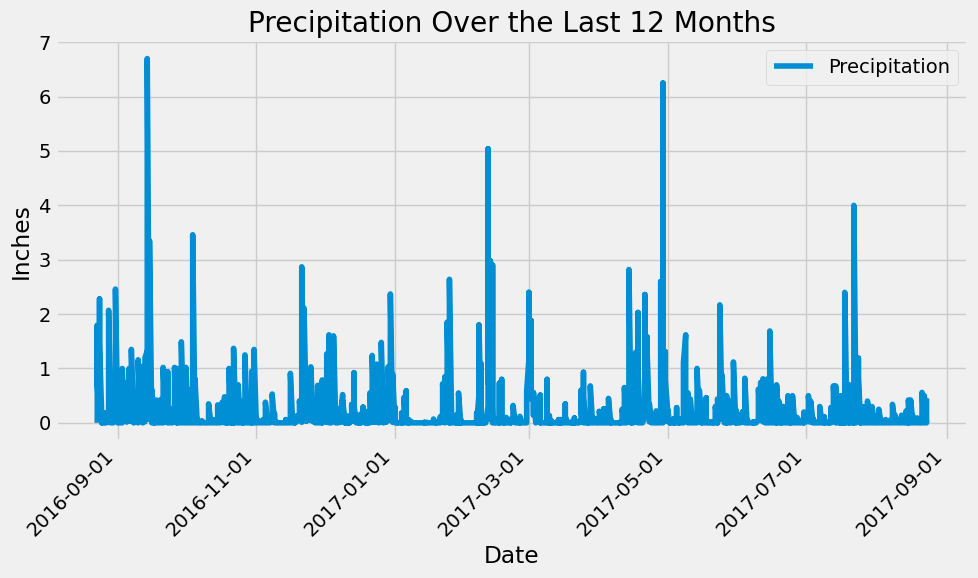

In [85]:
plt.style.use('fivethirtyeight')

df['Date'] = pd.to_datetime(df['Date'])

df.sort_index(inplace=True)

# Find the most recent date in the DataFrame
most_recent_date = df.index.max()

# Plotting the data
df.plot(x='Date', y='Precipitation', figsize=(10, 6), title='Precipitation Over the Last 12 Months', label='Precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')

# Setting the x-axis major formatter to display dates in 'year-month-day' format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Optionally, rotate date labels for better readability
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

In [86]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary = df['Precipitation'].describe()
print(summary)


count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [87]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(station).count()
station_count

9

In [88]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

most_active_stations = session.query(
    measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()

most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [89]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
USC00519281_info = session.query(measurement.station,func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)).\
    filter(measurement.station == 'USC00519281').all()

USC00519281_info

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

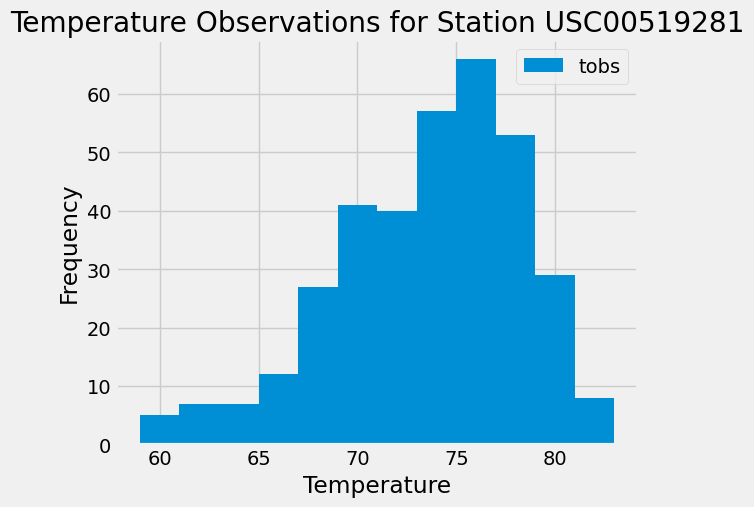

In [90]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
USC00519281_data = session.query(measurement.date, measurement.tobs).\
    filter(measurement.station == 'USC00519281').\
    filter(text("date >= (SELECT date(MAX(date), '-365 day') FROM measurement)")).\
    order_by(measurement.date).all()

df = pd.DataFrame(USC00519281_data, columns=['date', 'tobs'])

# Plot the results as a histogram
plt.figure(figsize=(6, 5))
df['tobs'].plot(kind='hist', bins=12, title='Temperature Observations for Station USC00519281',label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.show()


# Close Session

In [91]:
# Close Session
session.close()